# Bayesian statistics

Buyer beware: I am not a professional statistician.  

How I think about statistics:

- You setup a [statistical _model_](https://en.wikipedia.org/wiki/Statistical_model) which is a
mathematical description of the probability of seeing observations from a population.
- You perform some form of [statistical _inference_](https://en.wikipedia.org/wiki/Statistical_inference),
namely draw some conclusions about the model based upon an observed sample of the population.


### Regression example

Our model is that the relationship between the independent variable $x$ and the dependent variable $y$
is that
$$ y = a + bx + \epsilon $$
where $\epsilon$ is normally distributed with mean $0$ and variance $\sigma^2$, and that different
samples have independent $\epsilon$s.

Here the [_parameters_](https://en.wikipedia.org/wiki/Parametric_model) $a,b,\sigma^2$ are unknown.

Classical regression, using least squares fitting, is actually just
[Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood) estimation of the parameters.
That is, find $a,b,\sigma^2$ which make the probability of seeing the data (according to the model) the greatest.


### Philosophical problems

The talk of "populations" and "samples" makes a lot of sense for abstract problems, like tossing
a coin; and make some sense when we speak about e.g. the height of women in the UK.

I find it somewhat harder to understand in cases where the population is not "large", or
where we are not measuring e.g. physical properties.  In the article we have been discussing,
the data are not _measurements_ but are (subjective) responses to a survey.  What is the
"population" here?  We could conceivably study the whole population in this case.  What
meaning does maximum likelihood estimation have here-- we already have all the data.

I also tend to find hypothesis testing to be difficult to understand: I think because
it often takes the form of a [counter-factual](https://en.wikipedia.org/wiki/Counterfactual_conditional).


### Bayesian statistics

To [quote wikipedia](https://en.wikipedia.org/wiki/Bayesian_statistics):

> One of the key ideas of Bayesian statistics is that "probability is orderly opinion, and that inference from data is nothing other than the revision of such opinion in the light of relevant new information."

The key ideas are:

- We formulate our current (formally, [_prior_](https://en.wikipedia.org/wiki/Prior_distribution)) belief about
the statistic model.
- We update our prior by using the data we have to form the [_posterior_](https://en.wikipedia.org/wiki/Posterior_distribution).
This captures the combination of our prior beliefs combined with the observed data.  The key mathematical idea here
is [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)  (Off topic: confusingly, in most modern approaches to
probability, this is a definition or an axiom).
- We produce summary statistics, visualisations etc. of the posterior to summarise our new understanding of the
model.

Historically, Bayesian statistics has suffered from being mathematically intractable.  Fortunately,
ubiquitous, fast computing has solved many of these problems, and modern high-level programming
languages allow computing posteriors to be fast and easy.  This is what I aim to talk about.

(I also, personally, wonder if the use of computers as a _visualisation_ tool has also improved the acceptance of Bayesian techniques.  I find it hard to think about posterior distributions without a visual aid; compare this to the easy of computing a single number-- the p-value).

I find Bayesian statistics more conceptually understandable: it is nothing more than a coherent way to
answer the question: "What does the data tell me about my model?"  


# The most simple regression model

Let's assume, as the article seems to do, that we are working with Standardized Coefficients, so that in particular $\sum_i x_i = 0 = \sum_i y_i$.  Under this assumption, the regression model becomes simply

$$ y_i = \beta x_i + \epsilon_i. $$

Let's see how much FEM (the % of PhD recipients who are female in each subject area) correlates with FAB (the field-specific ability belief).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

In [2]:
frame = pd.read_csv("input.csv")

In [3]:
x = scipy.stats.zscore(frame["FAB"])
y = scipy.stats.zscore(frame["FEM"])
result = scipy.stats.linregress(x, y)
result

LinregressResult(slope=-0.60089543293578851, intercept=2.4690449890573367e-16, rvalue=-0.60089543293578851, pvalue=0.00044585366326165736, stderr=0.15105872541556611)

This doesn't give an estimate of $\sigma^2$.  My trust statistics notes tell me that:

- If $R = \sum_i y_i^2 - n \overline{y}^2 - \sum_i w_i^2 \hat b^2$ the _residual sum of squares_ (not to be confused with the "r value")
- then $R / (n-2)$ is an unbiased estimator (i.e. "increasingly good for large $n$") of $\sigma^2$.

Estimated sigma^2 is 0.684562155725


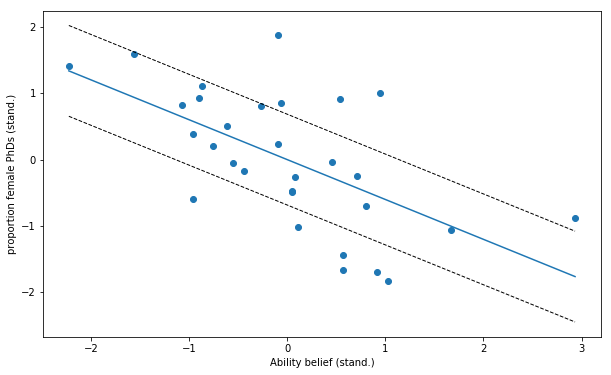

In [31]:
n = len(y)
R = np.sum(y*y) - n * np.mean(y)**2 - result.slope**2 * np.sum(x*x)
sigmasq = R / (n - 2)
print("Estimated sigma^2 is", sigmasq)

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y)
ax.set(xlabel="Ability belief (stand.)", ylabel="proportion female PhDs (stand.)")
xcs = np.linspace(min(x), max(x), 100)
ax.plot(xcs, xcs * result.slope)
ax.plot(xcs, xcs * result.slope + sigmasq, linewidth=1, color="black", linestyle="--")
ax.plot(xcs, xcs * result.slope - sigmasq, linewidth=1, color="black", linestyle="--")
None

### Assess model fit

If the model fits well, then $y_i - bx_i = \epsilon_i$ should be iid samples from $N(0,\sigma^2)$.  We can use a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) to check this.

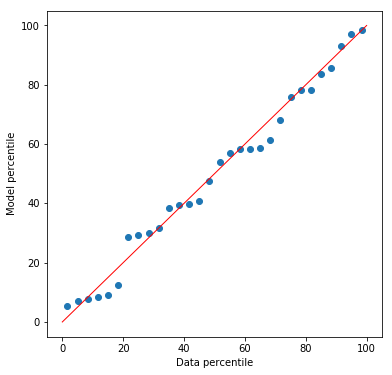

In [36]:
e = y - x * result.slope

e = np.sort(e)
q_data = (np.arange(len(e)) + 0.5) / len(e) * 100
normal_dist = scipy.stats.norm(loc=0, scale=np.sqrt(sigmasq))
q_est = [normal_dist.cdf(ee) * 100 for ee in e]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(q_data, q_est)
ax.set(xlabel="Data percentile")
ax.set(ylabel="Model percentile")
ax.plot([0,100],[0,100],color="red", linewidth=1)
None

# Bayesian approach

We have to decide on prior distributions for $b$ and $\sigma^2$.  I'll start with a simple (but not usually applied) example, as a warm up to using `pymc3`.  Later we will look at genuine "non-informative priors".

We don't have any prior knowledge, except that $b$ and $\sigma^2$ should both be small.  So let's set the priors to the normal distributions, with mean $0$, and large variance.

I'll use `pymc3` here.  See the end of this notebook for installation instructions.

In [38]:
import pymc3 as pm
import theano.tensor as tt

In [40]:
with pm.Model() as model:
    b = pm.Normal("b", mu=0, sd=100)
    s = pm.Normal("s", mu=0, sd=100)
    
    predicated = tt.dot(b, x)
    obs = pm.Normal("y", mu=predicated, sd=abs(s), observed=y)
    
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 11000/11000 [00:16<00:00, 668.98it/s]


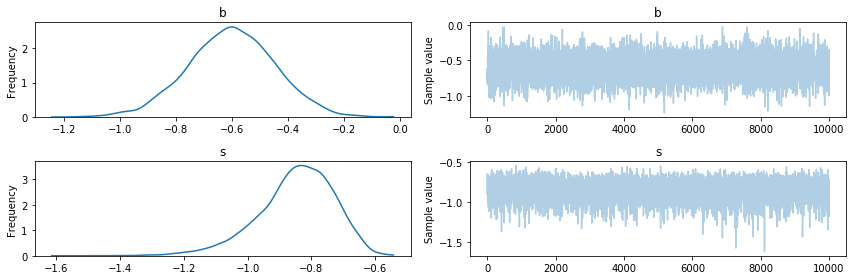

In [41]:
axes = pm.traceplot(trace)

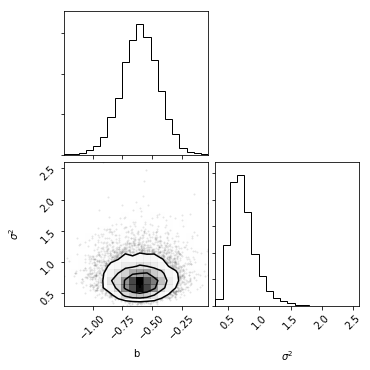

In [50]:
import corner

samples = np.asarray([trace.get_values("b"), trace.get_values("s")**2]).T
fig = corner.corner(samples, labels=["b", "$\sigma^2$"])

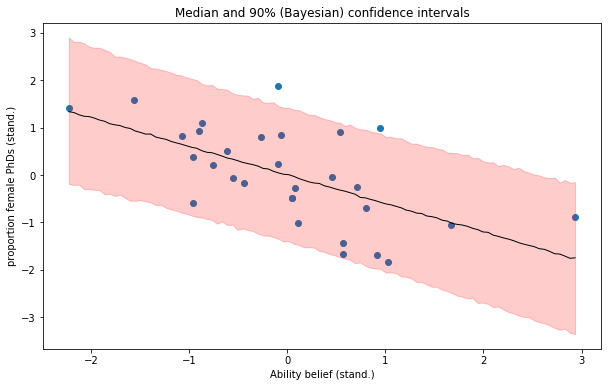

In [65]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y)
ax.set(xlabel="Ability belief (stand.)", ylabel="proportion female PhDs (stand.)")

xcs = np.linspace(min(x), max(x), 100)

b = trace.get_values("b")
s = np.abs(trace.get_values("s"))

#lower, median, upper = [], [], []
#for xx in xcs:
#    samples = np.random.normal(loc=b * xx, scale=s)
#    l, m, u = np.percentile(samples, [5, 50, 95])
#    lower.append(l)
#    median.append(m)
#    upper.append(u)

# numpy magic to do the above
samples = np.random.normal(loc=b[:,None] * xcs[None,:], scale=s[:,None])
lower, median, upper = np.percentile(samples, [5,50,95], axis=0)
    
ax.plot(xcs, median, linewidth=1, color="black")
ax.fill_between(xcs, lower, upper, color="red", alpha=0.2)
ax.set_title("Median and 90% (Bayesian) confidence intervals")
None

## So what just happened?

We used the `pymc3` package to sample from the posterior, using a [Probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming_language) paradigm.

### Theano and the use of `tt`

`pymc3` is built on top of `theano` which provides a framework for peforming `numpy`-like calculations, but in a "lazy evaluation" framework.

- Under the hood, `theano` stores information about the calculations I would _like_ to perform, but doesn't actually do any calculation.
- At the end, it works out the best way to perform the calculation.
- On my laptop, this seems to involve compiling some C code on the fly.
- In principle, it can also use GPUs and HPC clusters, if available.
- Some benchmarking, with simple code, shows this to be no quicker than `numpy`, at least on this laptop. YMMV.

That explains the use of `theano.tensor`, imported as `tt`.  Think of it as a drop-in replacement for `numpy` (which we normally import as `np`.  So change `np` to `tt` and continue as you were.)

### Probabilistic programming

    with pm.Model() as model:
    
This defines a Python `context` under which the rest of the calculation will occur.  (For programming language fanatics, this provides a nice way to provide an interface that _looks like_ we're using global state, while actually nicely encapsulating it).

        b = pm.Normal("b", mu=0, sd=100)
        
This defines a "stochastic variable".  We can use `b` like a normal variable, but really it's a "random variable" distributed as a Normal distribution, with mean 0 and standard deviation 100.  The `"b"` gives the `pmyc3` name, and it's good practice to keep this the same as the Python name.

        s = pm.Normal("s", mu=0, sd=100)
        
Defines another stochastic variable.

        predicated = tt.dot(b, x)
        
To explain this, we need to think back to our model,
$$ y = bx + \epsilon $$
where $\epsilon \sim N(0,\sigma^2)$.  So, we are defining `predicted` to be $bx$.  Here we use `tt` instead of `np`, as above, and use `dot` instead of `b * x` because `b` and `x` are really vectors of data.

        obs = pm.Normal("y", mu=predicated, sd=abs(s), observed=y)
        
So, our model can be re-written as $ y-bx = \epsilon$ or equivalently
$$ y-bx \sim N(0, \sigma^2). $$
By linearity, this is the same as
$$ y \sim N(bx,\sigma^2). $$
Then the code `pm.Normal("y", mu=predicated, sd=abs(s)` would setup a stochastic variable of name `y`, normally distributed with mean `predicted` (which is $bx$ as we want) and standard deviation `abs(s)` which is $\sqrt(\sigma^2) = |\sigma|$ as we want.

However, `y` is not a random variable, it is data!  This explains the extra key-word argument `observed=y` which tells `pymc3` that actually this is an "observed" variable, with actual data given by the `numpy` array `y`.
    
Thus we have completely specified our model, and our priors.  What remains is to compute the posterior.  We cannot do this analytically, but we can _sample_ from the posterior distribution.  That's what this line does:
    
    trace = pm.sample(10000, tune=1000)
    
Here we request 10000 samples, with a "tune" time of 1000.

Some magic occurs, we wait a while, and `trace` becomes usable.  The line

    pm.traceplot(trace)
    
produces some summary plots from the trace, which provide a quick visual check that everything is okay.

The code

    trace.get_values("b")
    
extracts the samples for the variable named `b` from the trace (gives a numpy array of size 10000).  I use the package [`corner`](https://corner.readthedocs.io/en/latest/) to visualise how `b` and `s` interact.

Finally, we produce a scatter plot.  For a fixed value of $x$, the model says that $y = bx + \epsilon$ with $\epsilon \sim N(0,\sigma^2)$.  Using the posterior distributions for $b$ and $\sigma$, we hence get a probability distribution for $y$.   Again, to compute this exactly is hard, but we can again use our samples:

- For each sample for $b$ and $\sigma$, take further sample from $N(0,\sigma^2)$ to get $\epsilon$, and then form $y = bx+\epsilon$.
- Then from all 10000 samples for $y$, compute some summary.  I use `numpy` to find the median and 5% and 95% percentiles, thus giving a (Bayesian) 90% confidence interval for $y$, given the model and the posterior distribution of the parameters.
- Notice here that "confidence interval" has a clear meaning: it is the 90% most likely region for $y$ to fall in, given the model and the data.  Compare this to the classical meaning of confidence interval, which involves hypothetical "repeated experiments".

I perform this for each $x$, and so produce curves.  They are not completely smooth because of the stochastic nature of the procedure.

# Installing `pmyc3`

If you are using Anaconda, this is as simple as

    conda install pymc3
    
This takes _forever_ as a very large number of packages are downloaded.

If you are not using Anaconda then, well, good luck...

[`corner`](https://corner.readthedocs.io/en/latest/) is pure Python, and can be easily installed as

    pip install corner

# A bit more mathematics

I haven't yet actually said what Bayes' theorem is!  We shall tend to work with continuous distributions, so let's state this in terms of distribution functions.

The parameters we're interested in we be denoted by $\theta$, typically a vector.  What we care about is the posterior distribution of $\theta$ given the data, namely

$$ p\big(\theta \mid \text{data}\big). $$

What we know is the prior distribution, $p(\theta)$ say, and the likelihood, which is probability of seeing the data given the parameters (this is what the "model" sets out),

$$ p\big(\text{data} \mid \theta\big). $$

Bayes' theorem says that

$$ p\big(\theta \mid \text{data}\big) p(\text{data}) = p\big(\text{data} \mid \theta) p(\theta)
\qquad \implies \qquad
p\big(\theta \mid \text{data}\big) = \frac{p(\text{data} \mid \theta) p(\theta)}{p(\text{data})}. $$
Notice that we know both terms in the numerator of the fraction, but sadly we don't know $p(\text{data})$.  Actually, $p(\text{data})$ is just a normalisation factor,
$$ p(\text{data}) = \int_\theta p(\text{data} \mid \theta) p(\theta) \ d\theta $$
which makes sure that $p(\theta\mid\text{data})$ is a _probability_ distribution.

- One approach is to hope that the product $p(\text{data} \mid \theta) p(\theta)$, as a function of $\theta$, has a standard form (that is, is a standard distribution you can find in a textbook).  This idea leads to the theory of [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior).
- Then $p(\text{data})$ can be found by looking in a book (that is, using the work of some previous statistian).
- Actually, for classical regression, this approach works well, and so, strictly speaking, we don't need the heavy tools of `pymc3`.  See other notebooks in my GitHub repo.

For more complicated models, we are not so lucky.  The modern approach is to give up on calculating $p(\theta\mid\text{data})$ and instead seek to generate _samples_ from the distribution.   That is, seek a more computational approach.  As if by magic, it turns out that many computational sampling techniques do _not_ require a probability density, only that we know the density up to a constant.  In short, we get away with not knowing $p(\text{data})$.  Both `pymc3` and `emcee` using [MCMC (Markov Chain Monte Carlo)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling techniques; Stan and WinBUGS for `R` use the same techniques.